## Cell 1: Mount Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Cell 2: Install Required packages

In [2]:
# Install required packages
!pip install -q xgboost scikit-learn pandas numpy matplotlib seaborn

## Cell 3: Import Libraries

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import json
import joblib
import glob
import os
from datetime import datetime
import time
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, f1_score, log_loss
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Cell 4: Configuration

In [4]:
# Paths
DATA_PATH = '/content/drive/MyDrive/CIC-IDS2018/training-v2/*.csv'
MODEL_DIR = '/content/drive/MyDrive/CIC-IDS2018/model-final-20251207/'

os.makedirs(MODEL_DIR, exist_ok=True)

# Essential features
ESSENTIAL_FEATURES = [
    'Dst Port', 'Protocol', 'Flow Duration',
    'Tot Fwd Pkts', 'Tot Bwd Pkts',
    'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
    'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
    'Flow Byts/s', 'Flow Pkts/s',
    'Flow IAT Mean', 'Flow IAT Std',
    'Fwd IAT Mean', 'Fwd IAT Std',
    'Fwd Pkts/s', 'Bwd Pkts/s',
    'Pkt Len Mean', 'Pkt Len Std',
    'SYN Flag Cnt', 'FIN Flag Cnt', 'RST Flag Cnt',
    'PSH Flag Cnt', 'ACK Flag Cnt',
    'Down/Up Ratio', 'Pkt Size Avg',
    'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Bwd Pkts',
    'Init Fwd Win Byts', 'Init Bwd Win Byts',
    'Fwd Header Len', 'Bwd Header Len'
]

TARGET_LABELS = [
    'Benign',
    'SSH-Bruteforce',
    'DoS attacks-Hulk',
    'DoS attacks-GoldenEye',
    'DoS attacks-Slowloris',
    'DDOS attack-HOIC'
]

TRAIN_SIZE = 0.7
VAL_SIZE = 0.1
TEST_SIZE = 0.2
RANDOM_STATE = 42
CHUNK_SIZE = 200000

MAX_BENIGN_SAMPLES = 170000
MAX_ATTACK_SAMPLES_PER_CLASS = 230000
NOISE_LEVEL = 0.03

print("✓ Configuration loaded")
print(f"Max Benign = {MAX_BENIGN_SAMPLES:,}")
print(f"Max per attack class = {MAX_ATTACK_SAMPLES_PER_CLASS:,}")
print(f"Noise level = {NOISE_LEVEL*100:.1f}%")

✓ Configuration loaded
Max Benign = 170,000
Max per attack class = 230,000
Noise level = 3.0%


## Cell 5: Helper Functions

In [5]:
def clean_column_names(df):
    df.columns = df.columns.str.strip()
    return df

def load_and_filter_data(file_path, features, target_labels, chunk_size=CHUNK_SIZE):
    print(f"Loading: {os.path.basename(file_path)}")
    chunks = []
    total_rows = 0

    for chunk in pd.read_csv(file_path, chunksize=chunk_size, low_memory=False):
        chunk = clean_column_names(chunk)
        if 'Label' in chunk.columns:
            chunk = chunk[chunk['Label'].isin(target_labels)]
            if len(chunk) > 0:
                available_features = [f for f in features if f in chunk.columns]
                chunk = chunk[available_features + ['Label']]
                chunks.append(chunk)
                total_rows += len(chunk)

    if chunks:
        df = pd.concat(chunks, ignore_index=True)
        print(f"  ✓ Loaded {total_rows:,} rows")
        return df
    return pd.DataFrame()

def add_noise_to_features(X, noise_level=0.05, random_state=None):
    np.random.seed(random_state)
    X_noisy = X.copy()

    numeric_cols = X.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        col_std = X[col].std()
        if col_std > 0:
            noise = np.random.normal(0, noise_level * col_std, size=len(X))
            X_noisy[col] = X[col] + noise

    return X_noisy

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    logloss = log_loss(y_test, y_proba)

    max_confidences = y_proba.max(axis=1)
    mean_confidence = max_confidences.mean()

    print(f"\n{model_name} Performance:")
    print("="*40)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Log Loss:  {logloss:.4f}")
    print(f"Mean Confidence: {mean_confidence:.4f}")

    if accuracy > 0.97 or mean_confidence > 0.90:
        print("\n❌ Model may be OVERFITTING!")
    elif accuracy > 0.90 and mean_confidence < 0.85:
        print("\n✓ EXCELLENT!")
    else:
        print("\n⚠️ Model may be underperforming")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'log_loss': logloss,
        'mean_confidence': mean_confidence,
        'predictions': y_pred,
        'probabilities': y_proba
    }

print("✓ Helper functions defined")

✓ Helper functions defined


## Cell 6: Load Data

In [6]:
print("\n" + "="*60)
print("LOADING DATASET")
print("="*60 + "\n")

dfs = []
for file_path in glob.glob(DATA_PATH):
    df = load_and_filter_data(file_path, ESSENTIAL_FEATURES, TARGET_LABELS)
    if not df.empty:
        dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
print(f"\nTotal samples loaded: {len(df):,}")
del dfs
gc.collect()


LOADING DATASET

Loading: Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
  ✓ Loaded 762,384 rows
Loading: Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
  ✓ Loaded 855,215 rows
Loading: Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
  ✓ Loaded 1,048,575 rows
Loading: Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
  ✓ Loaded 908,684 rows
Loading: Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
  ✓ Loaded 1,046,845 rows

Total samples loaded: 4,621,703


104

## Cell 7: Class Balancing

In [7]:
print("\n" + "="*60)
print("CLASS BALANCING")
print("="*60 + "\n")

label_counts = df['Label'].value_counts()
print("Original distribution:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label:25s}: {count:10,} ({percentage:5.2f}%)")

balanced_dfs = []
for label in TARGET_LABELS:
    label_df = df[df['Label'] == label]

    if label == 'Benign':
        max_samples = MAX_BENIGN_SAMPLES
    else:
        max_samples = MAX_ATTACK_SAMPLES_PER_CLASS

    if len(label_df) > max_samples:
        label_df = label_df.sample(n=max_samples, random_state=RANDOM_STATE)
        print(f"   {label:25s}: Downsampled {len(df[df['Label'] == label]):,} → {max_samples:,}")
    else:
        print(f"   {label:25s}: Kept all {len(label_df):,} samples")

    balanced_dfs.append(label_df)

df_balanced = pd.concat(balanced_dfs, ignore_index=True)
df_balanced = df_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"\n✓ Balanced dataset size: {len(df_balanced):,}")
print("\nNew distribution:")
new_counts = df_balanced['Label'].value_counts()
for label, count in new_counts.items():
    percentage = (count / len(df_balanced)) * 100
    print(f"  {label:25s}: {count:10,} ({percentage:5.2f}%)")

del df, balanced_dfs
gc.collect()


CLASS BALANCING

Original distribution:
  Benign                   :  3,233,692 (69.97%)
  DDOS attack-HOIC         :    686,012 (14.84%)
  DoS attacks-Hulk         :    461,912 ( 9.99%)
  SSH-Bruteforce           :    187,589 ( 4.06%)
  DoS attacks-GoldenEye    :     41,508 ( 0.90%)
  DoS attacks-Slowloris    :     10,990 ( 0.24%)
   Benign                   : Downsampled 3,233,692 → 170,000
   SSH-Bruteforce           : Kept all 187,589 samples
   DoS attacks-Hulk         : Downsampled 461,912 → 230,000
   DoS attacks-GoldenEye    : Kept all 41,508 samples
   DoS attacks-Slowloris    : Kept all 10,990 samples
   DDOS attack-HOIC         : Downsampled 686,012 → 230,000

✓ Balanced dataset size: 870,087

New distribution:
  DDOS attack-HOIC         :    230,000 (26.43%)
  DoS attacks-Hulk         :    230,000 (26.43%)
  SSH-Bruteforce           :    187,589 (21.56%)
  Benign                   :    170,000 (19.54%)
  DoS attacks-GoldenEye    :     41,508 ( 4.77%)
  DoS attacks-Slowlori

0

## Cell 8: Train-Val-Test Split

In [8]:
print("\n" + "="*60)
print("TRAIN-VALIDATION-TEST SPLIT")
print("="*60 + "\n")

X = df_balanced[ESSENTIAL_FEATURES]
y = df_balanced['Label']
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VAL_SIZE/(TRAIN_SIZE+VAL_SIZE),
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print(f"Split sizes:")
print(f"  Training:   {len(X_train):,} samples")
print(f"  Validation: {len(X_val):,} samples")
print(f"  Test:       {len(X_test):,} samples")


TRAIN-VALIDATION-TEST SPLIT

Split sizes:
  Training:   609,060 samples
  Validation: 87,009 samples
  Test:       174,018 samples


## Cell 9: Data Cleaning

In [9]:
print("\n" + "="*60)
print("MINIMAL DATA CLEANING")
print("="*60 + "\n")

def minimal_clean(X, y, set_name="Dataset"):
    print(f"Cleaning {set_name}:")
    print(f"  Before: {len(X):,} samples")
    df = pd.concat([X, y], axis=1)
    df = df.replace([np.inf, -np.inf], np.nan)
    initial_len = len(df)
    df = df.dropna()
    print(f"  Missing values removed: {initial_len - len(df):,}")
    print(f"  After: {len(df):,} samples")
    return df[ESSENTIAL_FEATURES], df['Label']

X_train, y_train = minimal_clean(X_train, y_train, "Training set")
X_val, y_val = minimal_clean(X_val, y_val, "Validation set")
X_test, y_test = minimal_clean(X_test, y_test, "Test set")

print("\n✓ Final sizes:")
print(f"  Training:   {len(X_train):,}")
print(f"  Validation: {len(X_val):,}")
print(f"  Test:       {len(X_test):,}")


MINIMAL DATA CLEANING

Cleaning Training set:
  Before: 609,060 samples
  Missing values removed: 628
  After: 608,432 samples
Cleaning Validation set:
  Before: 87,009 samples
  Missing values removed: 91
  After: 86,918 samples
Cleaning Test set:
  Before: 174,018 samples
  Missing values removed: 174
  After: 173,844 samples

✓ Final sizes:
  Training:   608,432
  Validation: 86,918
  Test:       173,844


## Cell 10: Feature Scaling with Noise

In [10]:
for col in ESSENTIAL_FEATURES:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_train_scaled = add_noise_to_features(
    X_train_scaled,
    noise_level=NOISE_LEVEL,
    random_state=RANDOM_STATE
)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

## Cell 11: Sample Weights

In [11]:
print("\n" + "="*60)
print("COMPUTE SAMPLE WEIGHTS")
print("="*60 + "\n")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)

print("Boosting attack class weights by 1.4x...\n")
for idx, label in enumerate(label_encoder.classes_):
    if label != 'Benign':
        class_weights[idx] *= 1.4

sample_weights = np.array([class_weights[i] for i in y_train_encoded])

print("Adjusted class weights:")
for idx, label in enumerate(label_encoder.classes_):
    print(f"  {label:25s}: {class_weights[idx]:.4f}")


COMPUTE SAMPLE WEIGHTS

Boosting attack class weights by 1.4x...

Adjusted class weights:
  Benign                   : 0.8567
  DDOS attack-HOIC         : 0.8818
  DoS attacks-GoldenEye    : 4.8862
  DoS attacks-Hulk         : 0.8818
  DoS attacks-Slowloris    : 18.4541
  SSH-Bruteforce           : 1.0811


## Cell 12: XGBoost Configuration

In [12]:
print("\n" + "="*60)
print("XGBOOST CONFIGURATION")
print("="*60 + "\n")

xgb_params = {
    'objective': 'multi:softprob',
    'num_class': len(label_encoder.classes_),

    # Shallow trees
    'max_depth': 4,
    'min_child_weight': 20,
    'max_leaves': 8,

    # Slow learning
    'learning_rate': 0.005,
    'n_estimators': 300,

    # Regularization
    'gamma': 5.0,
    'reg_alpha': 10.0,
    'reg_lambda': 20.0,

    # Sampling
    'subsample': 0.5,
    'colsample_bytree': 0.4,
    'colsample_bylevel': 0.4,
    'colsample_bynode': 0.4,

    'eval_metric': ['mlogloss', 'merror'],
    'early_stopping_rounds': 30,

    'tree_method': 'hist',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 1
}

print(f"  max_depth: {xgb_params['max_depth']} (very shallow)")
print(f"  learning_rate: {xgb_params['learning_rate']} (very slow)")
print(f"  gamma: {xgb_params['gamma']} (extreme regularization)")
print(f"  reg_alpha: {xgb_params['reg_alpha']} (extreme L1)")
print(f"  reg_lambda: {xgb_params['reg_lambda']} (extreme L2)")
print(f"  subsample: {xgb_params['subsample']} (use only 50% data)")
print(f"  colsample_bytree: {xgb_params['colsample_bytree']} (use only 40% features)")
print(f"  early_stopping: {xgb_params['early_stopping_rounds']} rounds")


XGBOOST CONFIGURATION

  max_depth: 4 (very shallow)
  learning_rate: 0.005 (very slow)
  gamma: 5.0 (extreme regularization)
  reg_alpha: 10.0 (extreme L1)
  reg_lambda: 20.0 (extreme L2)
  subsample: 0.5 (use only 50% data)
  colsample_bytree: 0.4 (use only 40% features)
  early_stopping: 30 rounds


## Cell 13: Model Training

In [13]:
print("\n" + "="*60)
print("Training XGBoost...")
print("="*60)

xgb_model = xgb.XGBClassifier(**xgb_params)

start_time = time.time()
xgb_model.fit(
    X_train_scaled, y_train_encoded,
    sample_weight=sample_weights,
    eval_set=[(X_val_scaled, y_val_encoded)],
    verbose=50
)
train_time = time.time() - start_time

print(f"\n✓ Training completed in {train_time:.2f} seconds")
print(f"Best iteration: {xgb_model.best_iteration}")
print(f"Best validation loss: {xgb_model.best_score:.4f}")


Training XGBoost...
[0]	validation_0-mlogloss:1.78683	validation_0-merror:0.49303
[50]	validation_0-mlogloss:1.54279	validation_0-merror:0.26844
[100]	validation_0-mlogloss:1.34313	validation_0-merror:0.05450
[150]	validation_0-mlogloss:1.18853	validation_0-merror:0.05335
[200]	validation_0-mlogloss:1.05435	validation_0-merror:0.04860
[250]	validation_0-mlogloss:0.94355	validation_0-merror:0.04802
[299]	validation_0-mlogloss:0.85076	validation_0-merror:0.04689

✓ Training completed in 171.38 seconds
Best iteration: 291
Best validation loss: 0.0467


## Cell 14: Model Evaluation

In [14]:
xgb_results = evaluate_model(xgb_model, X_test_scaled, y_test_encoded, "XGBoost")


XGBoost Performance:
Accuracy:  0.9533
Precision: 0.9595
Recall:    0.9533
F1-Score:  0.9538
Log Loss:  0.8660
Mean Confidence: 0.4457

✓ EXCELLENT!


## Cell 15: Classification Report

In [15]:
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60 + "\n")
print(classification_report(
    y_test_encoded,
    xgb_results['predictions'],
    target_names=label_encoder.classes_,
    digits=4
))


CLASSIFICATION REPORT

                       precision    recall  f1-score   support

               Benign     0.9989    0.8394    0.9122     33826
     DDOS attack-HOIC     0.9816    1.0000    0.9907     46000
DoS attacks-GoldenEye     0.7126    0.9918    0.8293      8302
     DoS attacks-Hulk     0.9343    0.9452    0.9397     46000
DoS attacks-Slowloris     0.8145    0.9832    0.8910      2198
       SSH-Bruteforce     0.9908    0.9986    0.9947     37518

             accuracy                         0.9533    173844
            macro avg     0.9055    0.9597    0.9263    173844
         weighted avg     0.9595    0.9533    0.9538    173844



## Cell 16: Per-Class Confidence Analysis

In [16]:
print("\n" + "="*60)
print("PER-CLASS CONFIDENCE ANALYSIS")
print("="*60 + "\n")

y_proba = xgb_results['probabilities']

for idx, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test_encoded == idx
    if class_mask.sum() > 0:
        class_confidences = y_proba[class_mask].max(axis=1)
        mean_conf = class_confidences.mean()
        median_conf = np.median(class_confidences)
        print(f"{class_name:25s}: Mean={mean_conf:.3f}, Median={median_conf:.3f}")


PER-CLASS CONFIDENCE ANALYSIS

Benign                   : Mean=0.426, Median=0.455
DDOS attack-HOIC         : Mean=0.395, Median=0.357
DoS attacks-GoldenEye    : Mean=0.470, Median=0.525
DoS attacks-Hulk         : Mean=0.383, Median=0.387
DoS attacks-Slowloris    : Mean=0.557, Median=0.539
SSH-Bruteforce           : Mean=0.591, Median=0.647


## Cell 17: Confidence Distribution

In [17]:
#print("\n" + "="*60)
#print("CONFIDENCE DISTRIBUTION")
#print("="*60 + "\n")

#max_confs = y_proba.max(axis=1)
#bins = [0.0, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0]
#hist, _ = np.histogram(max_confs, bins=bins)

#print("Confidence ranges:")
#for i in range(len(bins)-1):
#    pct = hist[i] / len(max_confs) * 100
#    print(f"  {bins[i]:.2f}-{bins[i+1]:.2f}: {hist[i]:6,} samples ({pct:5.2f}%)")

## Cell 18: Save Models

In [18]:
print("\n" + "="*60)
print("SAVING MODELS AND ARTIFACTS")
print("="*60 + "\n")

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
joblib.dump(xgb_model, os.path.join(MODEL_DIR, 'xgboost_model.pkl'))
joblib.dump(label_encoder, os.path.join(MODEL_DIR, 'label_encoder.pkl'))
joblib.dump(scaler, os.path.join(MODEL_DIR, 'scaler.pkl'))

metadata = {
    'timestamp': timestamp,
    'model_type': 'xgboost_radical_antioverfitting',
    'features': ESSENTIAL_FEATURES,
    'target_labels': TARGET_LABELS,
    'class_weights': {label: float(class_weights[idx]) for idx, label in enumerate(label_encoder.classes_)},
    'max_benign_samples': MAX_BENIGN_SAMPLES,
    'max_attack_samples': MAX_ATTACK_SAMPLES_PER_CLASS,
    'noise_level': NOISE_LEVEL,
    'xgb_params': xgb_params,
    'performance': {
        'accuracy': float(xgb_results['accuracy']),
        'f1_score': float(xgb_results['f1_score']),
        'mean_confidence': float(xgb_results['mean_confidence'])
    }
}

with open(os.path.join(MODEL_DIR, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

config = {
    'features': ESSENTIAL_FEATURES,
    'labels': TARGET_LABELS,
    'model_type': 'xgboost',
    'version': timestamp
}
with open(os.path.join(MODEL_DIR, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2)

print(f"✓ Models saved to: {MODEL_DIR}")
print(f"  - config.json")
print(f"  - xgboost_model.pkl")
print(f"  - label_encoder.pkl")
print(f"  - scaler.pkl")
print(f"  - metadata.json")


SAVING MODELS AND ARTIFACTS

✓ Models saved to: /content/drive/MyDrive/CIC-IDS2018/model-final-20251207/
  - config.json
  - xgboost_model.pkl
  - label_encoder.pkl
  - scaler.pkl
  - metadata.json


# Visualisation

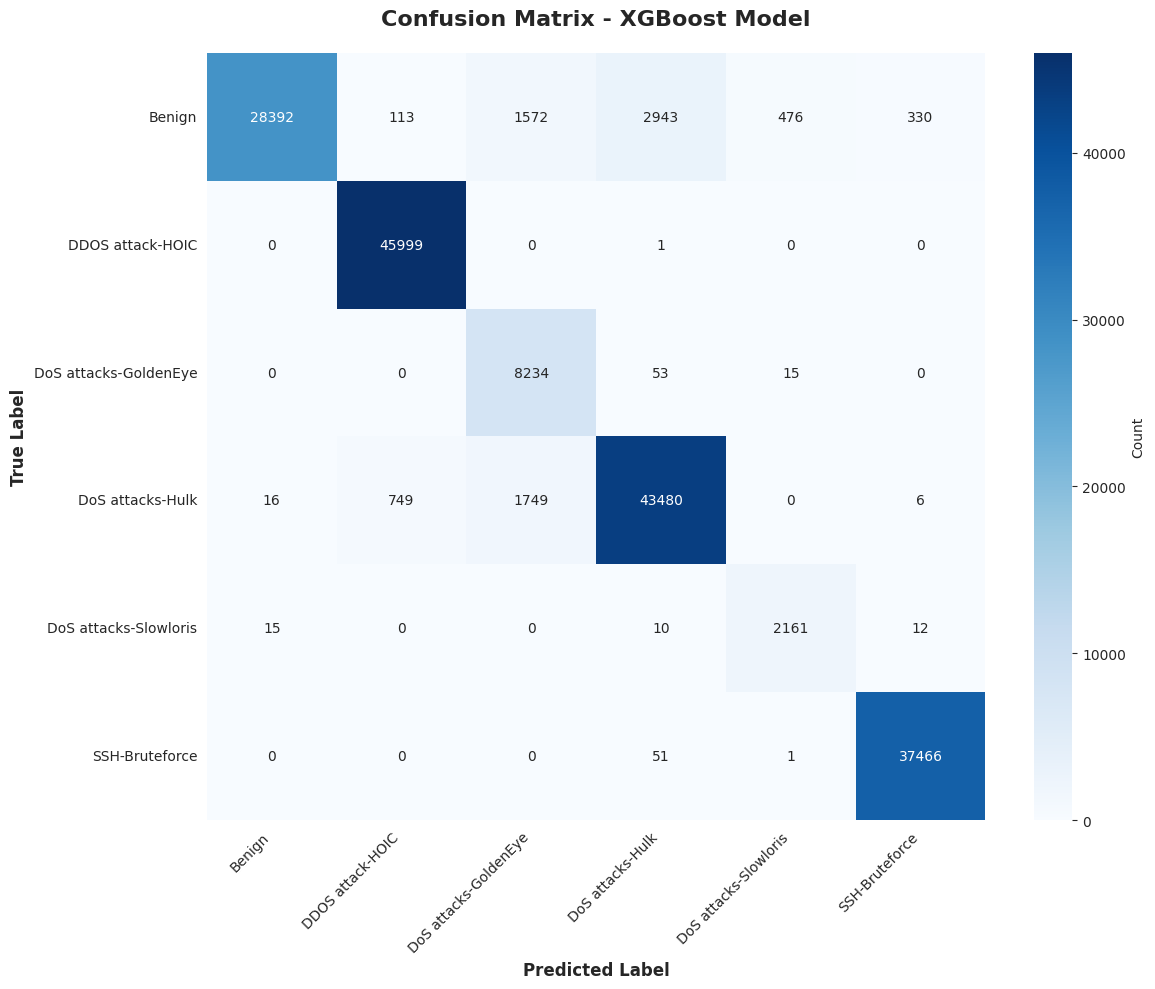

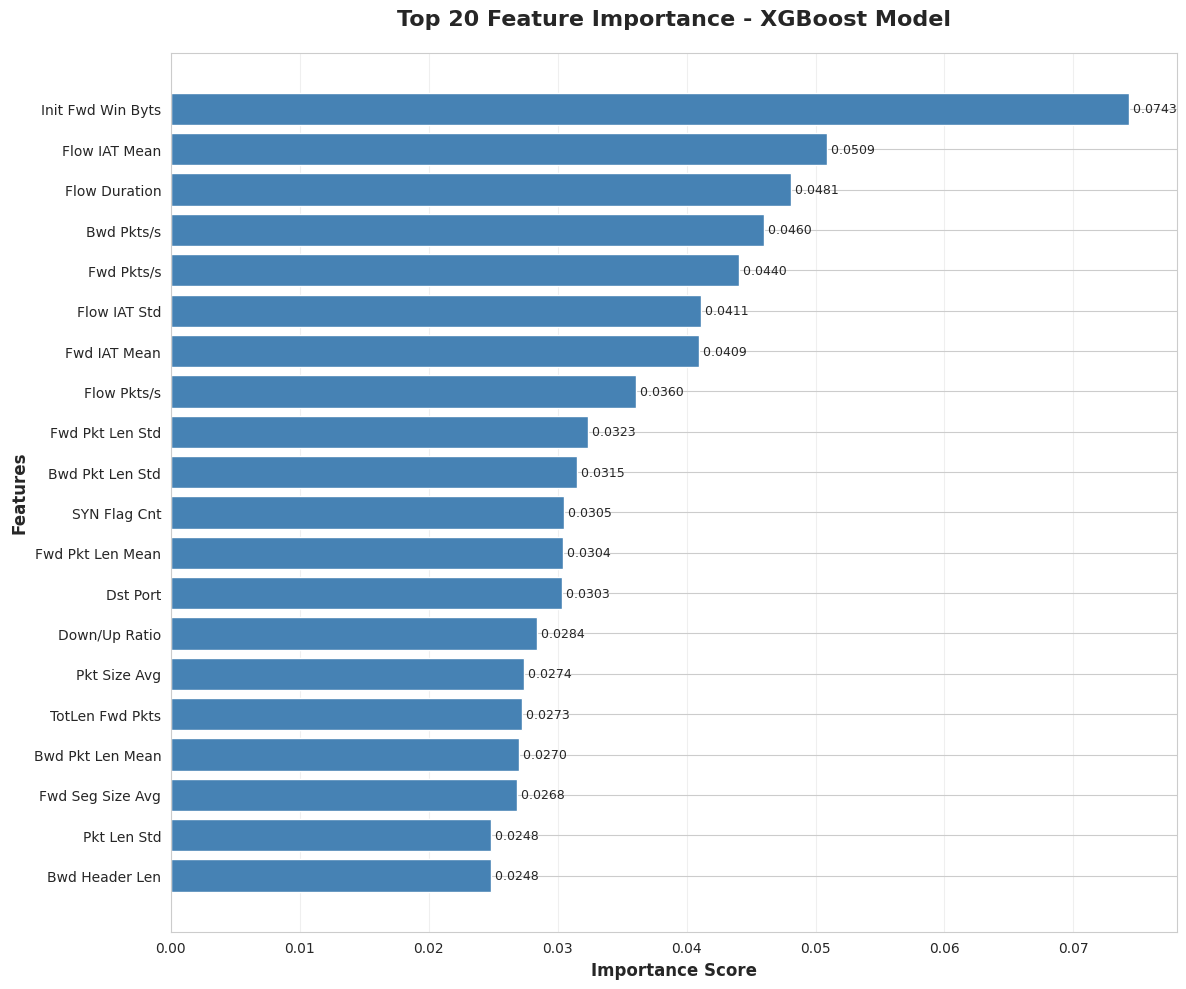

✓ Top 20 features plotted

Top 10 most important features:
  Init Fwd Win Byts             : 0.074284
  Flow IAT Mean                 : 0.050923
  Flow Duration                 : 0.048127
  Bwd Pkts/s                    : 0.045994
  Fwd Pkts/s                    : 0.044036
  Flow IAT Std                  : 0.041102
  Fwd IAT Mean                  : 0.040922
  Flow Pkts/s                   : 0.036049
  Fwd Pkt Len Std               : 0.032332
  Bwd Pkt Len Std               : 0.031511


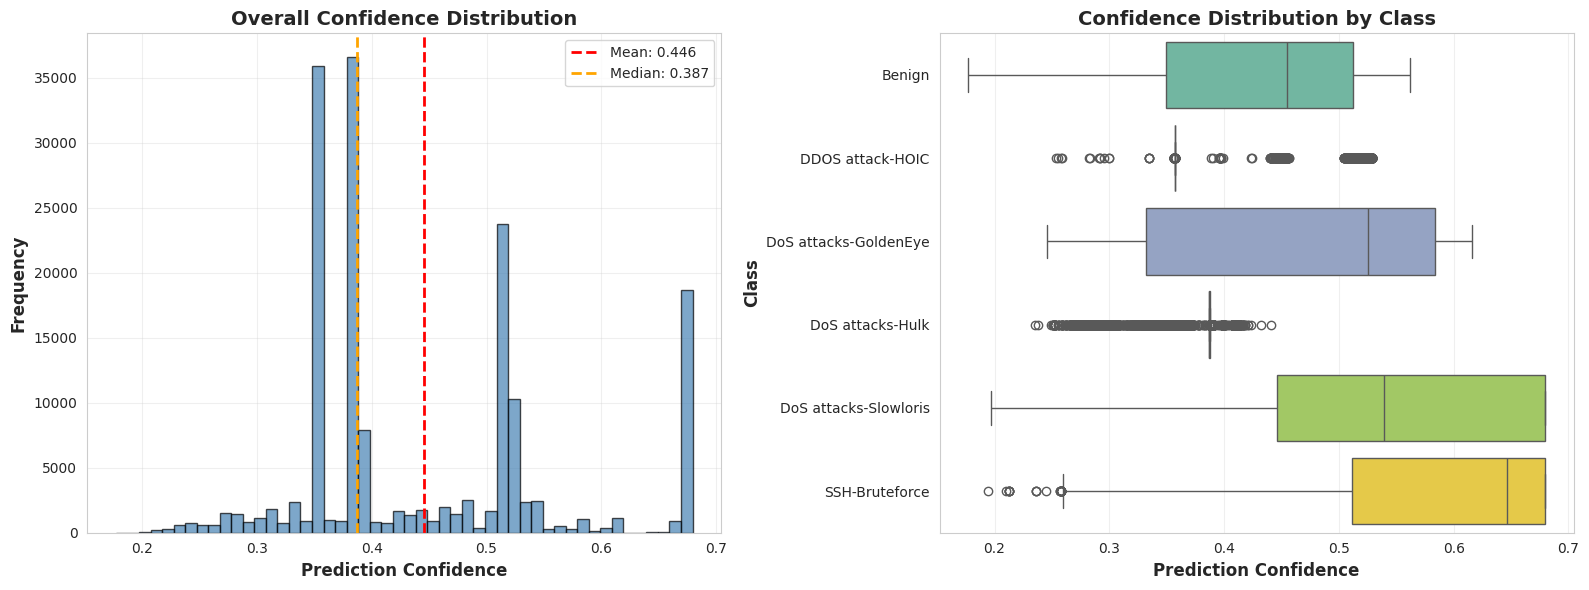

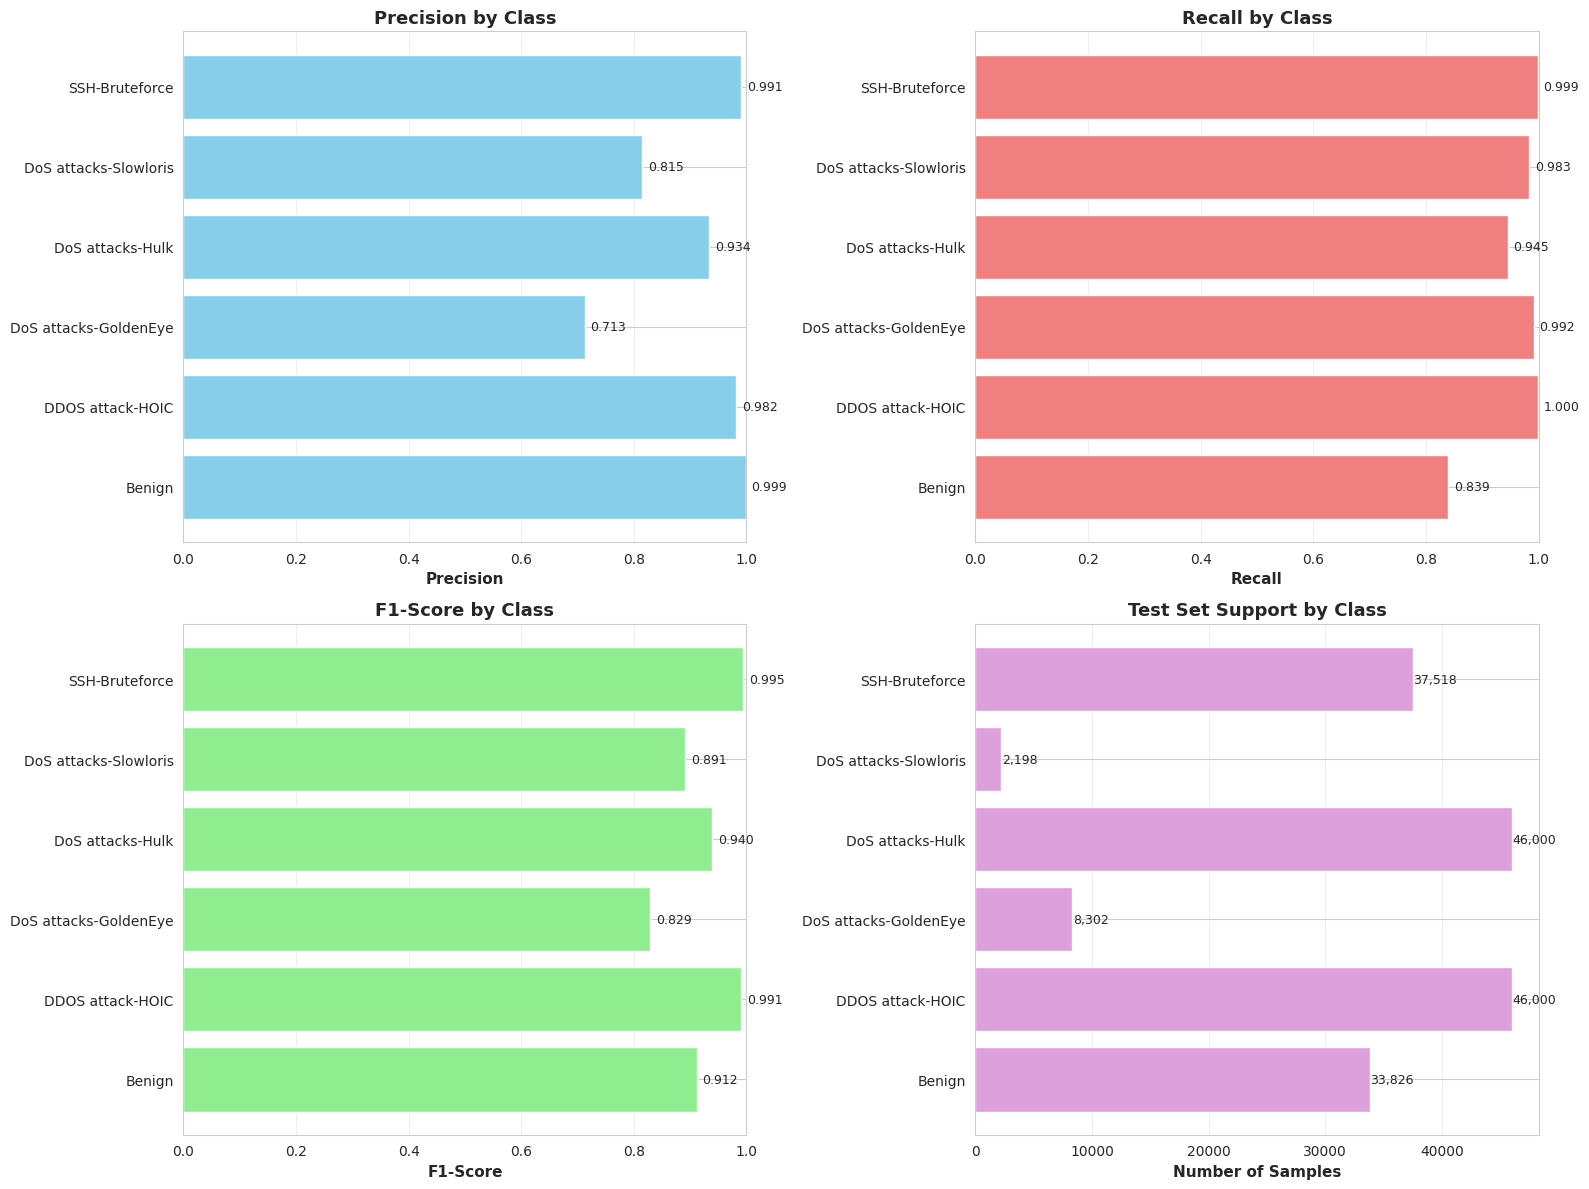


Metrics Summary:
                Class  Precision   Recall  F1-Score  Support
               Benign   0.998909 0.839354  0.912207    33826
     DDOS attack-HOIC   0.981605 0.999978  0.990707    46000
DoS attacks-GoldenEye   0.712592 0.991809  0.829330     8302
     DoS attacks-Hulk   0.934290 0.945217  0.939722    46000
DoS attacks-Slowloris   0.814550 0.983167  0.890950     2198
       SSH-Bruteforce   0.990797 0.998614  0.994690    37518


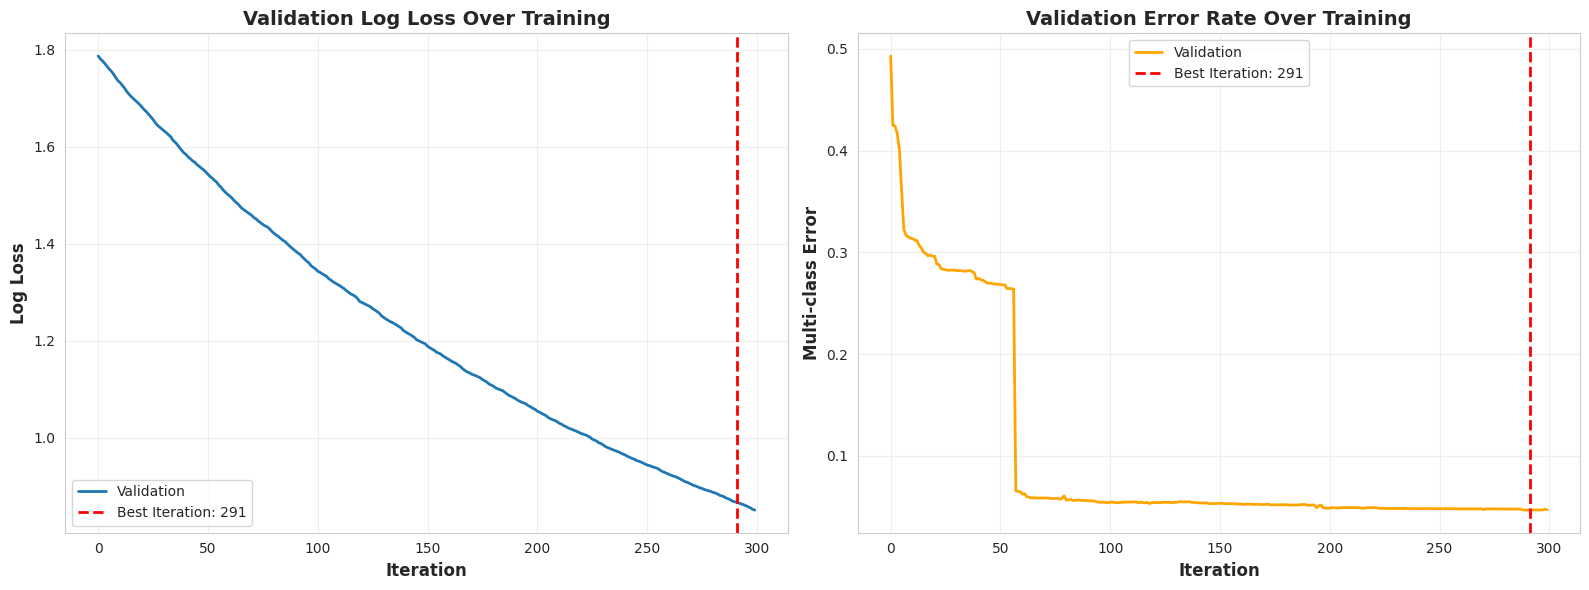

✓ Training converged at iteration 291/300
  Best validation log loss: 0.0467


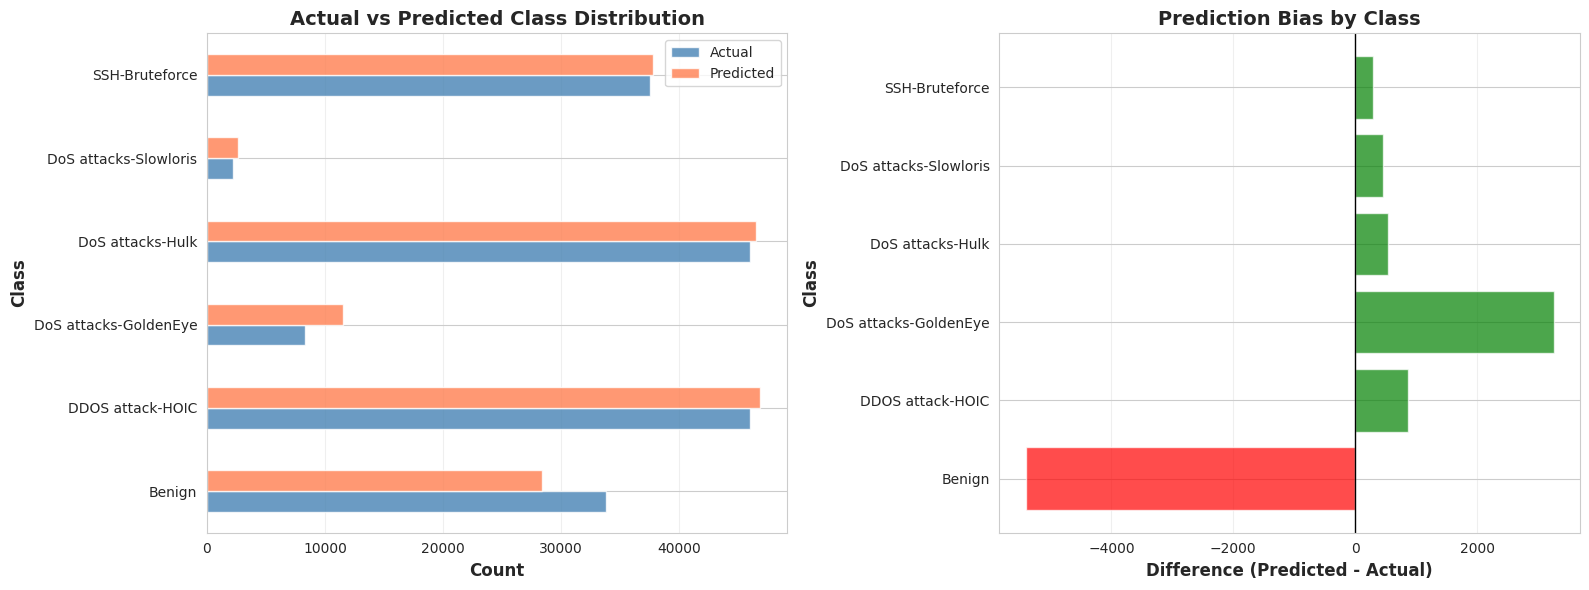

✓ Class distributions plotted

Distribution Summary:
                       Actual  Predicted  Difference
Benign                  33826      28423       -5403
DDOS attack-HOIC        46000      46861         861
DoS attacks-GoldenEye    8302      11555        3253
DoS attacks-Hulk        46000      46538         538
DoS attacks-Slowloris    2198       2653         455
SSH-Bruteforce          37518      37814         296
Total misclassifications: 8,112 out of 173,844
Misclassification rate: 4.67%



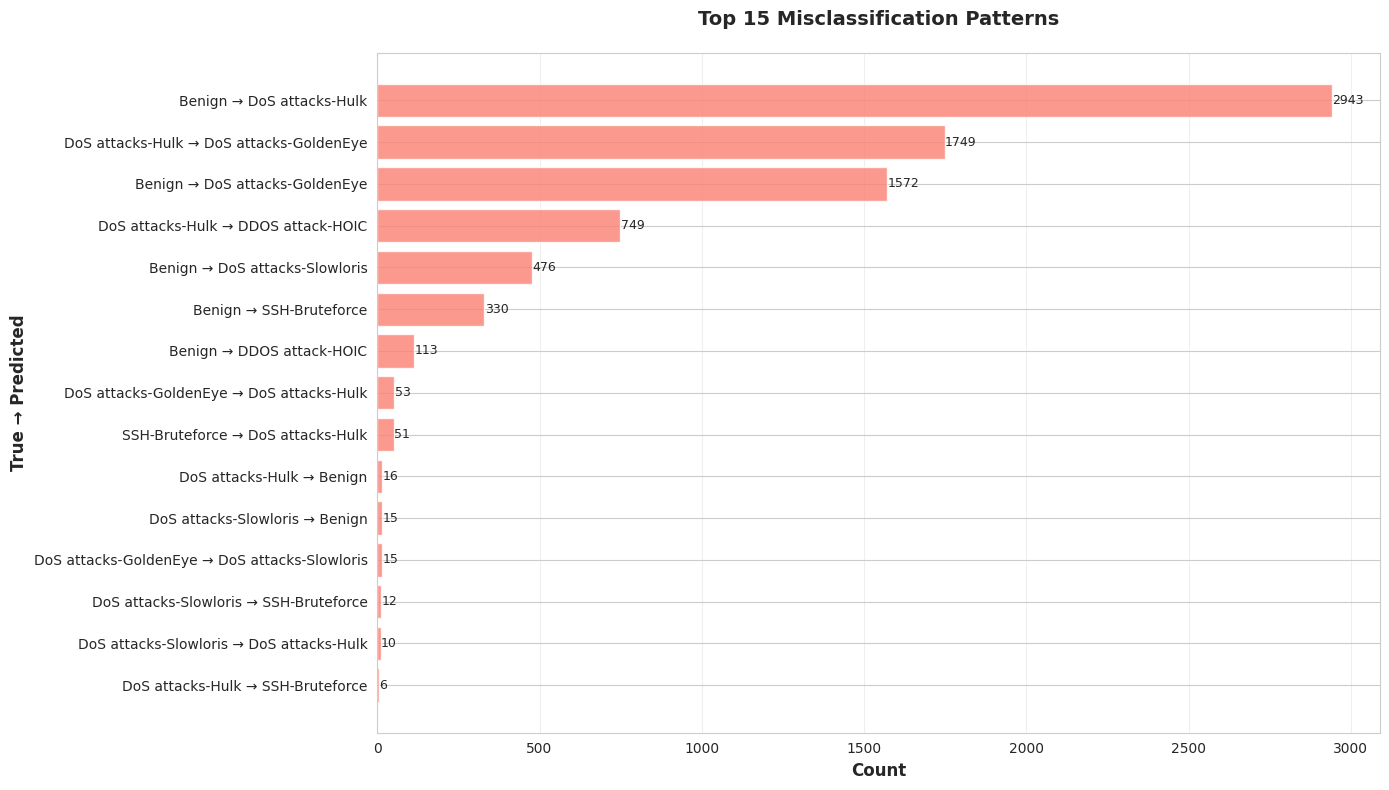

✓ Misclassification patterns plotted

Top 10 misclassification pairs:
  Benign → DoS attacks-Hulk                         : 2,943 (36.28%)
  DoS attacks-Hulk → DoS attacks-GoldenEye          : 1,749 (21.56%)
  Benign → DoS attacks-GoldenEye                    : 1,572 (19.38%)
  DoS attacks-Hulk → DDOS attack-HOIC               :   749 ( 9.23%)
  Benign → DoS attacks-Slowloris                    :   476 ( 5.87%)
  Benign → SSH-Bruteforce                           :   330 ( 4.07%)
  Benign → DDOS attack-HOIC                         :   113 ( 1.39%)
  DoS attacks-GoldenEye → DoS attacks-Hulk          :    53 ( 0.65%)
  SSH-Bruteforce → DoS attacks-Hulk                 :    51 ( 0.63%)
  DoS attacks-Hulk → Benign                         :    16 ( 0.20%)


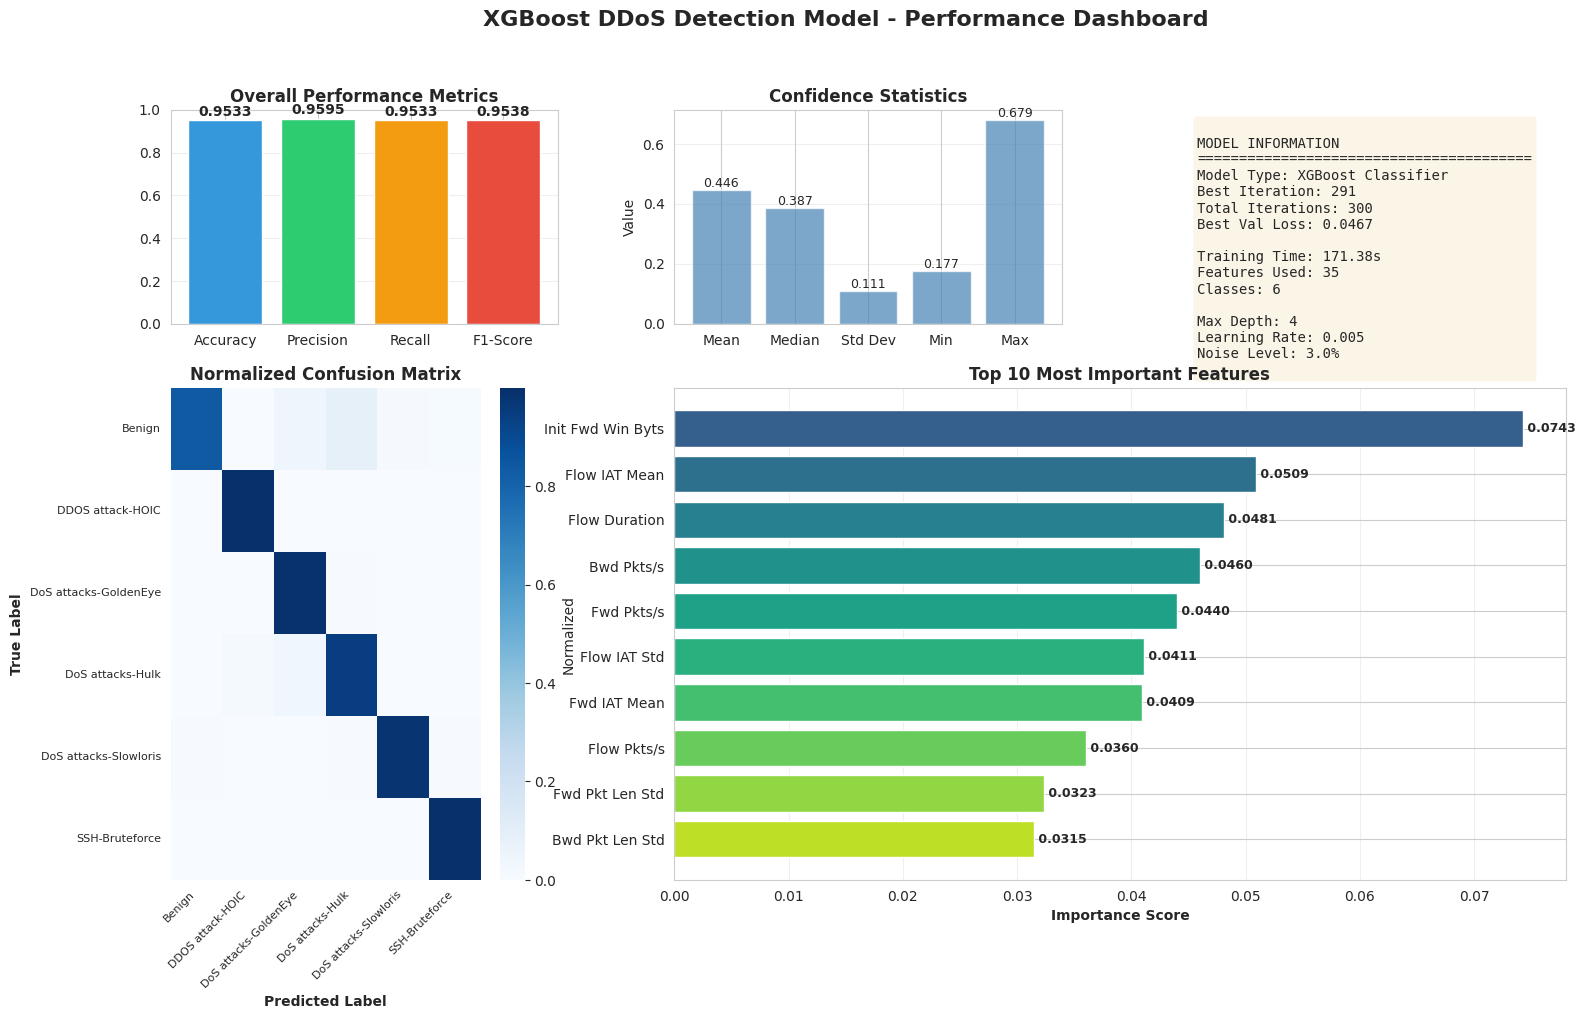

✓ Summary dashboard created

ALL VISUALIZATIONS COMPLETED

All plots saved to: /content/drive/MyDrive/CIC-IDS2018/model-final-20251207/


In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, xgb_results['predictions'])

# Create figure
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - XGBoost Model', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': ESSENTIAL_FEATURES,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

# Plot
plt.figure(figsize=(12, 10))
bars = plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importance - XGBoost Model', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['importance'], i, f" {row['importance']:.4f}",
             va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Top {top_n} features plotted")
print("\nTop 10 most important features:")
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.6f}")

# Get max confidence scores
max_confidences = xgb_results['probabilities'].max(axis=1)

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall distribution
axes[0].hist(max_confidences, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(max_confidences.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {max_confidences.mean():.3f}')
axes[0].axvline(np.median(max_confidences), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {np.median(max_confidences):.3f}')
axes[0].set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Overall Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Per-class confidence
class_confidences = []
class_labels = []
for idx, class_name in enumerate(label_encoder.classes_):
    class_mask = y_test_encoded == idx
    if class_mask.sum() > 0:
        class_conf = xgb_results['probabilities'][class_mask].max(axis=1)
        class_confidences.extend(class_conf)
        class_labels.extend([class_name] * len(class_conf))

conf_df = pd.DataFrame({'confidence': class_confidences, 'class': class_labels})
sns.boxplot(data=conf_df, y='class', x='confidence', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Prediction Confidence', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Class', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Distribution by Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'confidence_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_encoded,
    xgb_results['predictions'],
    labels=range(len(label_encoder.classes_))
)

# Create dataframe
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Precision
axes[0, 0].barh(metrics_df['Class'], metrics_df['Precision'], color='skyblue')
axes[0, 0].set_xlabel('Precision', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Precision by Class', fontsize=13, fontweight='bold')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_df['Precision']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Recall
axes[0, 1].barh(metrics_df['Class'], metrics_df['Recall'], color='lightcoral')
axes[0, 1].set_xlabel('Recall', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Recall by Class', fontsize=13, fontweight='bold')
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_df['Recall']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# F1-Score
axes[1, 0].barh(metrics_df['Class'], metrics_df['F1-Score'], color='lightgreen')
axes[1, 0].set_xlabel('F1-Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('F1-Score by Class', fontsize=13, fontweight='bold')
axes[1, 0].set_xlim(0, 1)
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_df['F1-Score']):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Support
axes[1, 1].barh(metrics_df['Class'], metrics_df['Support'], color='plum')
axes[1, 1].set_xlabel('Number of Samples', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Test Set Support by Class', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(metrics_df['Support']):
    axes[1, 1].text(v + 50, i, f'{int(v):,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'per_class_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))

# Extract training history
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Log Loss
axes[0].plot(x_axis, results['validation_0']['mlogloss'], label='Validation', linewidth=2)
axes[0].axvline(xgb_model.best_iteration, color='red', linestyle='--',
                label=f'Best Iteration: {xgb_model.best_iteration}', linewidth=2)
axes[0].set_xlabel('Iteration', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Log Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Validation Log Loss Over Training', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Multi-class Error
axes[1].plot(x_axis, results['validation_0']['merror'], label='Validation',
             color='orange', linewidth=2)
axes[1].axvline(xgb_model.best_iteration, color='red', linestyle='--',
                label=f'Best Iteration: {xgb_model.best_iteration}', linewidth=2)
axes[1].set_xlabel('Iteration', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Multi-class Error', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Error Rate Over Training', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training converged at iteration {xgb_model.best_iteration}/{epochs}")
print(f"  Best validation log loss: {xgb_model.best_score:.4f}")

# Get predictions
y_pred_labels = label_encoder.inverse_transform(xgb_results['predictions'])
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Count distributions
test_dist = pd.Series(y_test_labels).value_counts().sort_index()
pred_dist = pd.Series(y_pred_labels).value_counts().sort_index()

# Create comparison dataframe
dist_df = pd.DataFrame({
    'Actual': test_dist,
    'Predicted': pred_dist
}).fillna(0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
dist_df.plot(kind='barh', ax=axes[0], color=['steelblue', 'coral'], alpha=0.8)
axes[0].set_xlabel('Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Class', fontsize=12, fontweight='bold')
axes[0].set_title('Actual vs Predicted Class Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='x', alpha=0.3)

# Difference plot
dist_df['Difference'] = dist_df['Predicted'] - dist_df['Actual']
colors = ['green' if x >= 0 else 'red' for x in dist_df['Difference']]
axes[1].barh(dist_df.index, dist_df['Difference'], color=colors, alpha=0.7)
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Difference (Predicted - Actual)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Class', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Bias by Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'class_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Class distributions plotted")
print("\nDistribution Summary:")
print(dist_df.to_string())

# Find misclassifications
misclassified_mask = y_test_encoded != xgb_results['predictions']
misclassified_indices = np.where(misclassified_mask)[0]

print(f"Total misclassifications: {len(misclassified_indices):,} out of {len(y_test_encoded):,}")
print(f"Misclassification rate: {len(misclassified_indices)/len(y_test_encoded)*100:.2f}%\n")

# Analyze misclassification patterns
misclass_data = []
for idx in misclassified_indices:
    true_class = label_encoder.inverse_transform([y_test_encoded[idx]])[0]
    pred_class = label_encoder.inverse_transform([xgb_results['predictions'][idx]])[0]
    confidence = xgb_results['probabilities'][idx].max()
    misclass_data.append({
        'True': true_class,
        'Predicted': pred_class,
        'Confidence': confidence
    })

misclass_df = pd.DataFrame(misclass_data)

# Create confusion pairs
misclass_df['Pair'] = misclass_df['True'] + ' → ' + misclass_df['Predicted']
pair_counts = misclass_df['Pair'].value_counts().head(15)

# Plot top misclassification pairs
plt.figure(figsize=(14, 8))
plt.barh(range(len(pair_counts)), pair_counts.values, color='salmon', alpha=0.8)
plt.yticks(range(len(pair_counts)), pair_counts.index)
plt.xlabel('Count', fontsize=12, fontweight='bold')
plt.ylabel('True → Predicted', fontsize=12, fontweight='bold')
plt.title('Top 15 Misclassification Patterns', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()

for i, v in enumerate(pair_counts.values):
    plt.text(v + 1, i, str(v), va='center', fontsize=9)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, 'misclassification_patterns.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Misclassification patterns plotted")
print("\nTop 10 misclassification pairs:")
for pair, count in pair_counts.head(10).items():
    pct = count / len(misclassified_indices) * 100
    print(f"  {pair:50s}: {count:5,} ({pct:5.2f}%)")

# Create comprehensive dashboard
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall metrics
ax1 = fig.add_subplot(gs[0, 0])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [
    xgb_results['accuracy'],
    xgb_results['precision'],
    xgb_results['recall'],
    xgb_results['f1_score']
]
bars = ax1.bar(metrics_names, metrics_values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
ax1.set_ylim(0, 1)
ax1.set_title('Overall Performance Metrics', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(metrics_values):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# 2. Confidence stats
ax2 = fig.add_subplot(gs[0, 1])
conf_stats = {
    'Mean': max_confidences.mean(),
    'Median': np.median(max_confidences),
    'Std Dev': max_confidences.std(),
    'Min': max_confidences.min(),
    'Max': max_confidences.max()
}
ax2.bar(conf_stats.keys(), conf_stats.values(), color='steelblue', alpha=0.7)
ax2.set_title('Confidence Statistics', fontweight='bold', fontsize=12)
ax2.set_ylabel('Value')
ax2.grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(conf_stats.items()):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# 3. Training info
ax3 = fig.add_subplot(gs[0, 2])
ax3.axis('off')
info_text = f"""
MODEL INFORMATION
{'='*40}
Model Type: XGBoost Classifier
Best Iteration: {xgb_model.best_iteration}
Total Iterations: {epochs}
Best Val Loss: {xgb_model.best_score:.4f}

Training Time: {train_time:.2f}s
Features Used: {len(ESSENTIAL_FEATURES)}
Classes: {len(label_encoder.classes_)}

Max Depth: {xgb_params['max_depth']}
Learning Rate: {xgb_params['learning_rate']}
Noise Level: {NOISE_LEVEL*100:.1f}%
"""
ax3.text(0.05, 0.95, info_text, transform=ax3.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 4. Mini confusion matrix
ax4 = fig.add_subplot(gs[1:, 0])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', ax=ax4,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Normalized'})
ax4.set_title('Normalized Confusion Matrix', fontweight='bold', fontsize=12)
ax4.set_ylabel('True Label', fontweight='bold')
ax4.set_xlabel('Predicted Label', fontweight='bold')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax4.get_yticklabels(), rotation=0, fontsize=8)

# 5. Top features
ax5 = fig.add_subplot(gs[1:, 1:])
top_10_features = feature_importance.head(10)
colors_features = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_10_features)))
bars = ax5.barh(range(len(top_10_features)), top_10_features['importance'], color=colors_features)
ax5.set_yticks(range(len(top_10_features)))
ax5.set_yticklabels(top_10_features['feature'])
ax5.set_xlabel('Importance Score', fontweight='bold')
ax5.set_title('Top 10 Most Important Features', fontweight='bold', fontsize=12)
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(top_10_features.iterrows()):
    ax5.text(row['importance'], i, f" {row['importance']:.4f}",
             va='center', fontsize=9, fontweight='bold')

plt.suptitle('XGBoost DDoS Detection Model - Performance Dashboard',
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig(os.path.join(MODEL_DIR, 'model_dashboard.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✓ Summary dashboard created")
print(f"\n{'='*60}")
print("ALL VISUALIZATIONS COMPLETED")
print(f"{'='*60}")
print(f"\nAll plots saved to: {MODEL_DIR}")